프로젝트 개요  
- 상품 리뷰 데이터 분석을 통하여 상품 추천 여부를 예측하는 분류 모델 수행  
- 상품 추천 여부에 영향을 미치는 특성 데이터들에 대한 데이터 분석 수행  

프로젝트 목차 

데이터 읽기: 이커머스 데이터를 불러오고 Dataframe 구조를 확인  
데이터 정제: 비어 있는 데이터 또는 쓸모 없는 데이터를 삭제  
2.1. 결측값 확인  
2.2. 결측값 처리  

데이터 시각화: 변수 시각화를 통하여 분포 파악  
3.1. Title word cloud  
3.2. Review Text word cloud  
3.3. Recommended IND 시각화  
  
데이터 전 처리: 머신러닝 모델에 필요한 입력값 형식으로 데이터 처리  
4.1. 자연어 전 처리 - Tfidf  
4.2. 학습, 테스트 데이터 분리  
  
머신러닝 모델 학습: 분류 모델을 사용하여 학습 수행  
5.1. 기본 분류 모델 학습 - 의사결정나무  
5.2. 다양한 분류 모델 학습  
  
평가 및 예측: 학습된 모델을 바탕으로 평가 및 예측 수행  
6.1. Confusion Matrix  
6.2. Precision & Recall  
6.3. 테스트 데이터의 예측값 출력  

데이터 출처 : https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews


# 데이터 읽기

In [ ]:
!pip install wordcloud

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df_origin = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Clothing Reviews/Clothing_Reviews.csv")

In [ ]:
df_origin.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [ ]:
df_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [ ]:
df_origin.describe() # 수치형 변수 데이터만 요약해서 출력

,Unnamed: 0,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count
count,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000
mean,11742.500000,918.118709,43.198544,4.196032,0.822362,2.535936
std,6779.968547,203.298980,12.279544,1.110031,0.382216,5.702202
min,0.000000,0.000000,18.000000,1.000000,0.000000,0.000000
25%,5871.250000,861.000000,34.000000,4.000000,1.000000,0.000000
50%,11742.500000,936.000000,41.000000,5.000000,1.000000,1.000000
75%,17613.750000,1078.000000,52.000000,5.000000,1.000000,3.000000
max,23485.000000,1205.000000,99.000000,5.000000,1.000000,122.000000


# 데이터 정제

In [ ]:
# 의미 없는 변수인 'Unnamed: 0, Unnamed: 0.1'를 drop을 사용하여 삭제
df_clean = df_origin.drop(columns = ['Unnamed: 0'])

In [ ]:
# 결측값 정보를 출력.
df_clean.isnull().sum()

Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64

In [ ]:
# Division Name이 Null인 데이터 출력
df_clean[df_clean['Division Name'].isnull()]

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
9444,72,25,My favorite socks!!!,"I never write reviews, but these socks are so ...",5,1,0,NaN,NaN,NaN
13767,492,23,So soft!,I just love this hoodie! it is so soft and com...,5,1,1,NaN,NaN,NaN
13768,492,49,Wardrobe staple,Love this hoodie. so soft and goes with everyt...,5,1,0,NaN,NaN,NaN
13787,492,48,NaN,NaN,5,1,0,NaN,NaN,NaN
16216,152,36,Warm and cozy,"Just what i was looking for. soft, cozy and warm.",5,1,0,NaN,NaN,NaN
16221,152,37,Love!,I am loving these. they are quite long but are...,5,1,0,NaN,NaN,NaN
16223,152,39,"""long and warm""",These leg warmers are perfect for me. they are...,5,1,0,NaN,NaN,NaN
18626,184,34,Nubby footless tights,"These are amazing quality. i agree, size up to...",5,1,5,NaN,NaN,NaN
18671,184,54,New workhorse,These tights are amazing! if i care for them w...,5,1,0,NaN,NaN,NaN
20088,772,50,Comfy sweatshirt!,This sweatshirt is really nice! it's oversize...,5,1,0,NaN,NaN,NaN


In [ ]:
# 결측값이 아닌 부분만 df_clasn에 저장
df_clean = df_clean[~df_clean['Review Text'].isnull()]

# 결측값 정보를 출력
df_clean.isnull().sum()

Clothing ID                   0
Age                           0
Title                      2966
Review Text                   0
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                13
Department Name              13
Class Name                   13
dtype: int64

# 데이터 시각화

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re

## Title word cloud

In [ ]:
# 'Title'의 결측값을 삭제
df_clean_title = df_clean[~df_clean['Title'].isnull()]

# findall 함수를 사용하여 띄어 쓰기 단위로 글자만을 가져오기 (소문자로 변환도 수행)
tokens = re.findall("[\w']+", df_clean_title['Title'].str.lower().str.cat(sep=' ')) 

In [ ]:
# nltk에서 지원하는 'stopwords'를 다운로드
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# 영어 'stopwords'를 가져옵니다.
en_stops = set(stopwords.words('english'))

# tokens에서 'stopwords'에 해당되지 않는 단어를 골라내어 filtered_sentence에 저장합니다.
# 불용어 처리
filtered_sentence = [token for token in tokens if not token in en_stops]
filtered_sentence

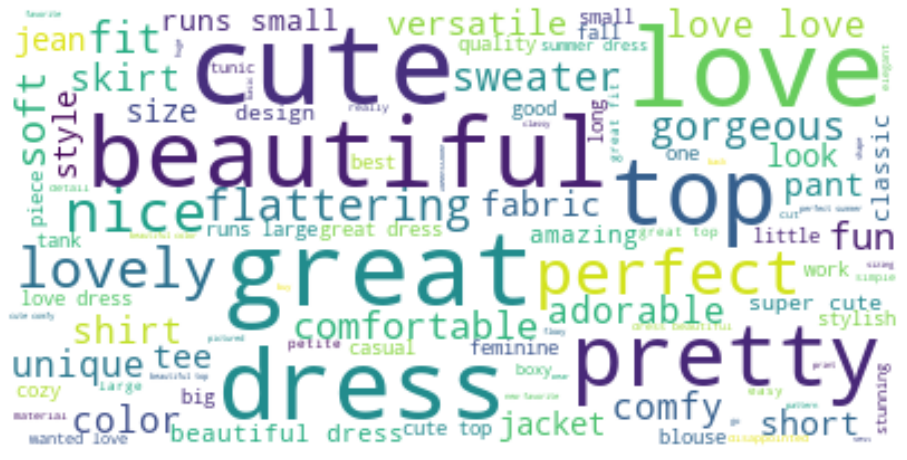

In [ ]:
# 출력 사이즈를 설정
plt.rcParams['figure.figsize'] = (16, 16)

wordcloud = WordCloud(max_font_size=50, max_words=100,background_color="white").generate(' '.join(filtered_sentence))

# wordcloud를 출력
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
# findall 함수를 사용하여 띄어 쓰기 단위로 글자만을 가져옵니다.(소문자로 변환도 수행)
tokens = re.findall("[\w']+", df_clean['Review Text'].str.lower().str.cat(sep=' ')) 

# tokens에서 'stopwords'에 해당되지 않는 단어를 골라내어 filtered_sentence에 저장합니다.
filtered_sentence = [token for token in tokens if not token in en_stops]
filtered_sentence

['absolutely',
 'wonderful',
 'silky',
 'sexy',
 'comfortable',
 'love',
 'dress',
 'sooo',
 'pretty',
 'happened',
 'find',
 'store',
 "i'm",
 'glad',
 'bc',
 'never',
 'would',
 'ordered',
 'online',
 'bc',
 'petite',
 'bought',
 'petite',
 "5'8",
 'love',
 'length',
 'hits',
 'little',
 'knee',
 'would',
 'definitely',
 'true',
 'midi',
 'someone',
 'truly',
 'petite',
 'high',
 'hopes',
 'dress',
 'really',
 'wanted',
 'work',
 'initially',
 'ordered',
 'petite',
 'small',
 'usual',
 'size',
 'found',
 'outrageously',
 'small',
 'small',
 'fact',
 'could',
 'zip',
 'reordered',
 'petite',
 'medium',
 'ok',
 'overall',
 'top',
 'half',
 'comfortable',
 'fit',
 'nicely',
 'bottom',
 'half',
 'tight',
 'layer',
 'several',
 'somewhat',
 'cheap',
 'net',
 'layers',
 'imo',
 'major',
 'design',
 'flaw',
 'net',
 'layer',
 'sewn',
 'directly',
 'zipper',
 'c',
 'love',
 'love',
 'love',
 'jumpsuit',
 'fun',
 'flirty',
 'fabulous',
 'every',
 'time',
 'wear',
 'get',
 'nothing',
 'great',

## 띄어쓰기 단위로 분리한 Title 출력

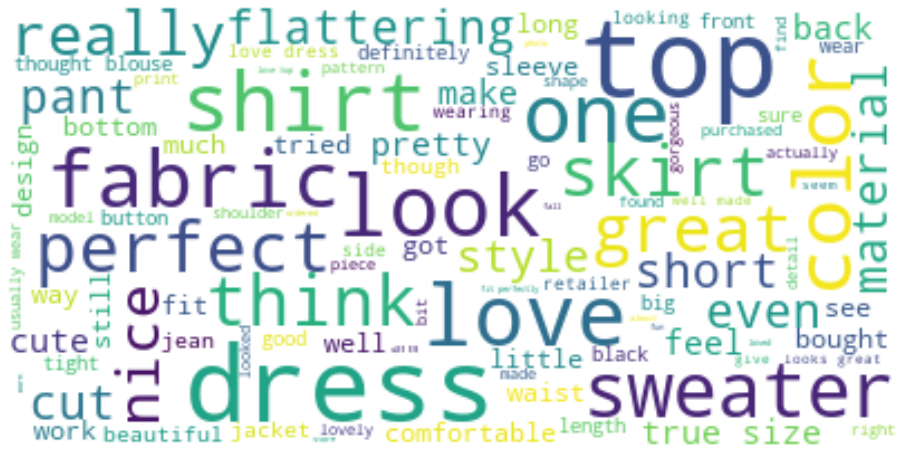

In [ ]:
# 출력 사이즈를 설정합니다.
plt.rcParams['figure.figsize'] = (16, 16)

# wordcloud를 저장합니다.
wordcloud = WordCloud(max_font_size=50, max_words=100,background_color="white").generate(' '.join(filtered_sentence))

# wordcloud를 출력합니다.
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

## Review Text world cloud

In [ ]:
# findall 함수를 사용하여 띄어 쓰기 단위로 글자 반환(소문자로 변환도 수행)
tokens = re.findall("[\w']+", df_clean['Review Text'].str.lower().str.cat(sep=' ')) 

# tokens에서 'stopwords'에 해당되지 않는 단어만 filtered_sentence에 저장
filtered_sentence = [token for token in tokens if not token in en_stops]
filtered_sentence

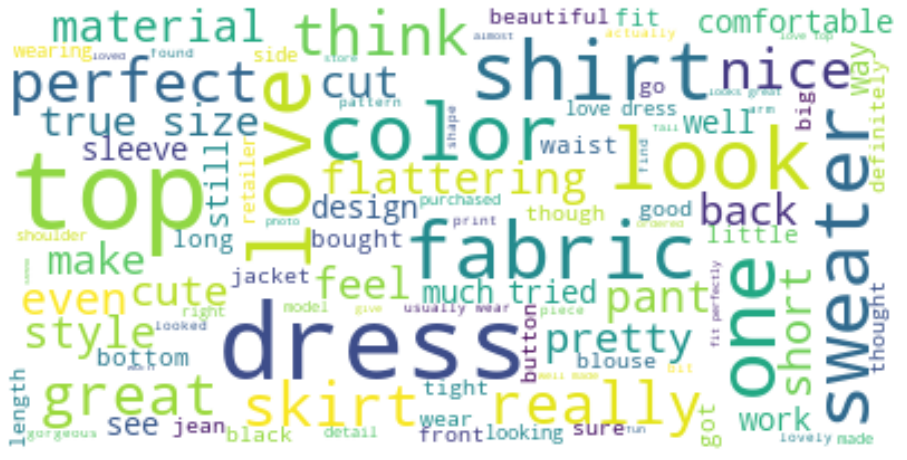

In [ ]:
plt.rcParams['figure.figsize'] = (16, 16)

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(filtered_sentence))

plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

1    18540
0     4101
Name: Recommended IND, dtype: int64

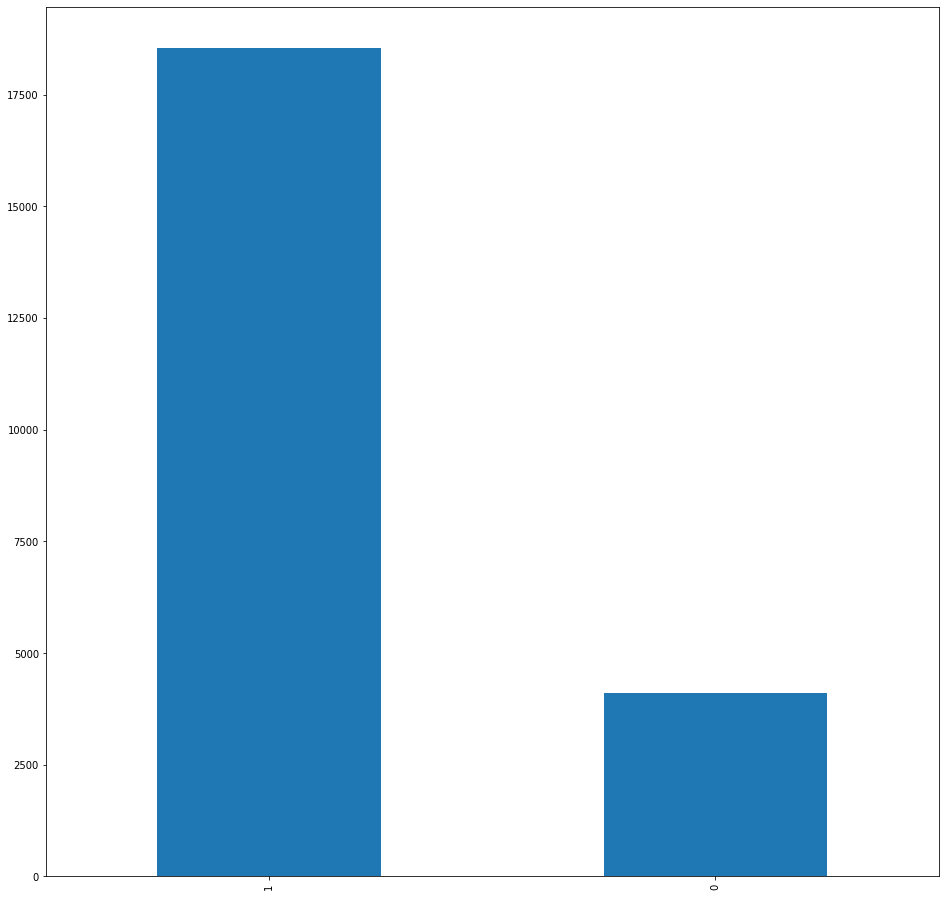

In [ ]:
# 분포를 막대 그래프를 사용하여 출력합니다.
df_clean['Recommended IND'].value_counts().plot(kind='bar')

# 분포를 도수분포표로 확인합니다.
df_clean['Recommended IND'].value_counts()

# 데이터 전처리

- 상품 추천 여부를 예측하기 위해 분류 모델 사용
- Review Text 데이터를 사용하여 예측 수행